<a href="https://colab.research.google.com/github/juanmantegazza/costo-seguro-medico/blob/main/Costo_de_Seguro_M%C3%A9dico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

Una prepaga quiere optimizar costos decidiendo los montos que cobra mensualmente a sus
socios de manera más eficaz. Para ello cuenta con una base de datos, disponible [aquí](https://www.kaggle.com/mirichoi0218/insurance), en la
que se resumen algunas características de sus asociados y el monto que pagan de cuota
médico/asistencial.


### 1. Configuración del Ambiente

1. Usaremos el API de kaggle para descargar el dataset, para ello, primero deberemos instalar el SDK con el comando pip. 

2. Luego importaremos las clase *KaggleApi* del modulo *kaggle_api_extended*, junto con el modulo os, que usaremos luego para configurar las credenciales. 

3. Una vez instalado el SDK, debemos configurar las credenciales para poder authenticar con el API de Kaggle, si bien las credenciales para authenticar son provistas como parte del notebook, se pueden generar siguiendo las instrucciones del siguiente [link](https://www.kaggle.com/docs/api#getting-started-installation-&-authentication). 


In [1]:
!pip install --upgrade kaggle # Instalacion del SDK de Kaggle

Requirement already up-to-date: kaggle in /usr/local/lib/python3.7/dist-packages (1.5.12)


In [2]:
import os
import numpy as np
import random

np.set_printoptions(precision=3, suppress=True) # y hago un truco para imprimir solamente 3 decimales
random.seed(10)
np.random.seed(10)

os.environ['KAGGLE_USERNAME'] = 'juanmante'
os.environ['KAGGLE_KEY'] = 'cc8287124cd0ee2680144730fee72277'

In [3]:
from kaggle.api.kaggle_api_extended import KaggleApi 

kaggle = KaggleApi()
kaggle.authenticate()

### 2. Descarga del dataset

In [4]:
from os import path
import pandas as pd

# establecemos las características del data set
insurance_dataset = dict()
insurance_dataset['url'] = 'https://www.kaggle.com/mirichoi0218/insurance'
insurance_dataset['dataset'] = 'mirichoi0218/insurance'

dataset_name = insurance_dataset['dataset'].split('/')[1]
zipfile = f"{dataset_name}.zip"

if not path.exists(zipfile):  # descargar solamente si no existe
  kaggle.dataset_download_files(insurance_dataset['dataset'])  
  !unzip $zipfile
else:
  print(f'El archivo {zipfile} ya existe.')

Archive:  insurance.zip
  inflating: insurance.csv           


### 3. Exploración de datos crudos

El primer paso para la exploración de datos crudos será leer el dataset con la función ```read_csv```, la cual, además, crea el objeto ```df```, que es el dataframe de la librería pandas.


Luego, será cuestión de llamar al método ```head``` sobre ```df``` para visualizar las primeras 5 instancias del dataset. 


In [5]:
import pandas as pd

# abrimos el archivo usando una función específica de pandas
df = pd.read_csv(f"{dataset_name}.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#Descripción del dataset - Features & Target

In [6]:
print('=============================')
print('MEDICAL COST PERSONAL DATASET')
print('Num samples: {}'.format(df.shape[0]))
print('Num features: {}'.format(df.shape[1]))
print('Feature names: {}'.format(df.columns.values))
print('=============================')

MEDICAL COST PERSONAL DATASET
Num samples: 1338
Num features: 7
Feature names: ['age' 'sex' 'bmi' 'children' 'smoker' 'region' 'charges']


Podemos ver que contamos 1338 instancias y las siguientes 7 features:

- **age**: age of primary beneficiary

- **sex**: insurance contractor gender, female, male

- **bmi**: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

- **children**: Number of children covered by health insurance / Number of dependents

- **smoker**: Smoking

- **region**: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

- **charges**: Individual medical costs billed by health insurance

De las cuales las features que usaremos para predecir nuestro target son: *age*, *sex*, *bmi*, *children*, *smoker*, *region* y nuestra variable objectivo a predecir será ***charges***.

Es decir, el objetivo será, a partir de una serie de atributos dados, poder predecir, para un nuevo ejemplo ***NO anotado***, los cargos que deberían cobrarse al individuo por el servicio de seguro.


# Análisis de los datos

A continuación, se realizará un análisis estadístico de carácter ***descriptivo*** para ver mas detalles de la composición del dataset.

In [7]:
df.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


Gracias al método ```describe```, podemos ver algunos datos interesanes:

- El promedio de edad es al rededor de 40 años, siendo la persona mas joven de 18 años y la mayor de 64.

- El promedio de hijos es cercano a 1, habiendo casos donde el individuo no tiene hijos o casos donde tiene 5 hijos, siendo este el máximo.

- El promedio del monto cobrado por el servicio de seguro ronda los 13.270 dólares.

Es importante revisar la presencia de valores nulos, ya que de haberlos, habría que tomar alguna acción correctiva (por ejemplo: eliminar la instancia o reemplazar el valor nulo por la media de la columna).

In [8]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Podemos observar que no hay valores nulos o vacios.

A continuación, realizaremos una serie de gráficos de barra, para obtener mayor información sobre como están distribuidos los datos de cada atributo en particular. 

Este proceso es altamente válido ya que nos ayuda a seguir conociendo más del dataset que estamos analizando y nos sirve para entender más del dominio.

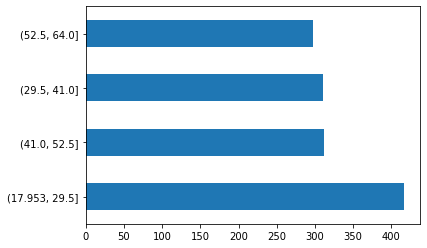

In [9]:
# graficamos el atributo 'age'
df['age'].value_counts(bins=4).plot.barh()

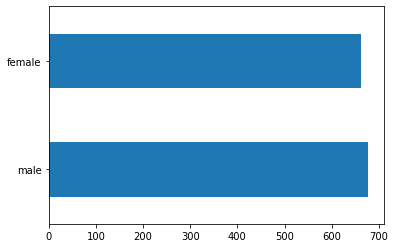

In [10]:
# graficamos el atributo 'sex'
df['sex'].value_counts().plot.barh()

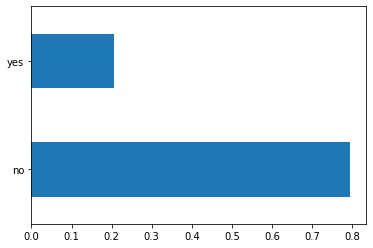

In [11]:
# graficamos el atributo 'smoker'
df['smoker'].value_counts(normalize=True).plot.barh()

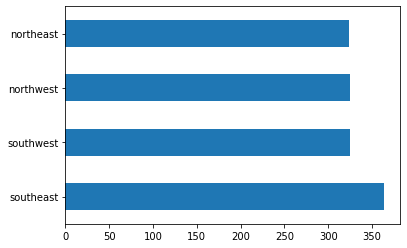

In [12]:
# graficamos el atributo 'region'
df['region'].value_counts().plot.barh()

Se puede observar que algunos de los datos estan equitativamente distribuidos, y otros no, por ejemplo, se puede observar que la cantidad de  asegurados entre los 20 y los 30 es mucho mayor que la de los  40/50 o 50/60, lo mismo sucede con los fumadores, podemos ver que casi el 80% de las personas son no fumadores.

# Pre procesado

En esta sección realizaremos transformaciones sobre el dataset. El objetivo será llevar el formato de los datos al mas conveniente para la posterior creación del modelo de aprendizaje.

- En primer lugar, aplicaremos  OneHot Encoding para pasar los atributos categóricos(**region**) a un formato numérico.

- En segundo lugar, aplicaremos binary encoding para los datos booleanos(**sex** y **smoke**). Sería un error aplicar OneHot Encoding acá ya que se generarían dos columnas innecesariamente, afectando negativamente al posterior algoritmo de aprendizaje.



In [13]:
pdf = pd.get_dummies(df, columns=['region'])
pdf['isSmoker'] = pdf['smoker'].map(dict(yes=1, no=0))
pdf['isFemale'] = pdf['sex'].map(dict(female=1, male=0))
pdf = pdf.drop(['sex', 'smoker'], axis=1)
pdf.head()

,age,bmi,children,charges,region_northeast,region_northwest,region_southeast,region_southwest,isSmoker,isFemale
0,19,27.900,0,16884.92400,0,0,0,1,1,1
1,18,33.770,1,1725.55230,0,0,1,0,0,0
2,28,33.000,3,4449.46200,0,0,1,0,0,0
3,33,22.705,0,21984.47061,0,1,0,0,0,0
4,32,28.880,0,3866.85520,0,1,0,0,0,0


Como podemos ver en el ```head```generado arriba, todos los atributos fueron transformados a valores numéricos.

Definimos un diccionario con tags para las features que vamos a mantener y sus descripciones. 

Además, generamos dos estructuras ```X_df``` e ```y_df```. La primera contendrá a todos los atributos menos la variable objetivo, y la segunda solamente la variable objetivo. 

In [14]:
feature_labels = dict()
feature_labels['age']='age of primary beneficiary'
feature_labels['sex']='insurance contractor gender, female, male'
feature_labels['bmi']='Body mass index'
feature_labels['children']='Number of children covered by health insurance / Number of dependents'
feature_labels['smoker']='Smoking'
feature_labels['region']='the beneficiarys residential area in the US, northeast, southeast, southwest, northwest'
feature_labels['charges']='Individual medical costs billed by health insurance'
insurance_dataset['feature-labels'] = feature_labels

# recuperamos únicamente las columnas que nos interesa mantener como features
X_df = pdf.drop(['charges'], axis=1)
# y armamos el arreglo de etiquetas
y_df = pdf.filter(['charges'])

Vemos lo que quedó en ```X_df```:

In [15]:
X_df.head()

,age,bmi,children,region_northeast,region_northwest,region_southeast,region_southwest,isSmoker,isFemale
0,19,27.900,0,0,0,0,1,1,1
1,18,33.770,1,0,0,1,0,0,0
2,28,33.000,3,0,0,1,0,0,0
3,33,22.705,0,0,1,0,0,0,0
4,32,28.880,0,0,1,0,0,0,0


Vemos lo que quedó en ```y_df```:

In [16]:
y_df.head()

,charges
0,16884.92400
1,1725.55230
2,4449.46200
3,21984.47061
4,3866.85520


### Generamos estructuras Numpy, con los valores de X_df e y_df

In [17]:
# pasamos lo dataframes a numpy
X = X_df.to_numpy()
y = y_df.to_numpy()

# chequeamos los tamaños de los nuevos conjuntos
print('X size: {}'.format(X.shape))
print('y size: {}'.format(y.shape))

# imprimimos las primeras 4 filas
print('First 4 rows from the desing matrix:')
print(X[0:4,:])
print('First 4 labels from the labels array:')
print(y[0:4])

X size: (1338, 9)
y size: (1338, 1)
First 4 rows from the desing matrix:
[[19.    27.9    0.     0.     0.     0.     1.     1.     1.   ]
 [18.    33.77   1.     0.     0.     1.     0.     0.     0.   ]
 [28.    33.     3.     0.     0.     1.     0.     0.     0.   ]
 [33.    22.705  0.     0.     1.     0.     0.     0.     0.   ]]
First 4 labels from the labels array:
[[16884.924]
 [ 1725.552]
 [ 4449.462]
 [21984.471]]


### 4. Análisis cuantitativo de los datos

**Matriz de Correlacion**

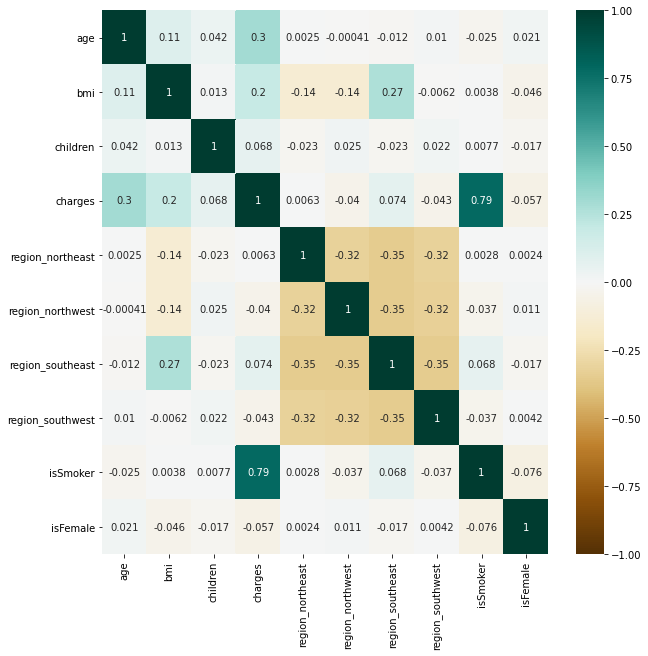

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Impresión de la matriz como un heatmap
plt.figure(figsize=(10, 10));
sns.heatmap(pdf.corr(), vmin=-1.0, vmax=1.0, center=0.0, annot=True, cmap='BrBG')

A partir de la matriz de correalción podemos observar que existe alguna correlación entre las features bmi, age, y isSmoker con charges, lo que estaría indicando que estas tendrían una gran incidencia en el costo que paga cada asociado.

También es posible observar algunos otros casos donde podría haber alguna correlación, como por ejemplo, bmi y algunas regiones o bmi y la edad, como por ejemplo la región southeast, sin embargo es poco concluyente y podrían ser solo ruido en los datos.

### 5. Análisis Numérico de los Datos

**Historamas**

Configuramos una Scatter Matrix para poder visualizar las distribuciones y relaciones entre pares de features.

Filtraremos las columnas de region dado que no tiene mucho sentido analizar este tipo de columnas, ya hemos visto que la distribucion de las regiones es equitativa.

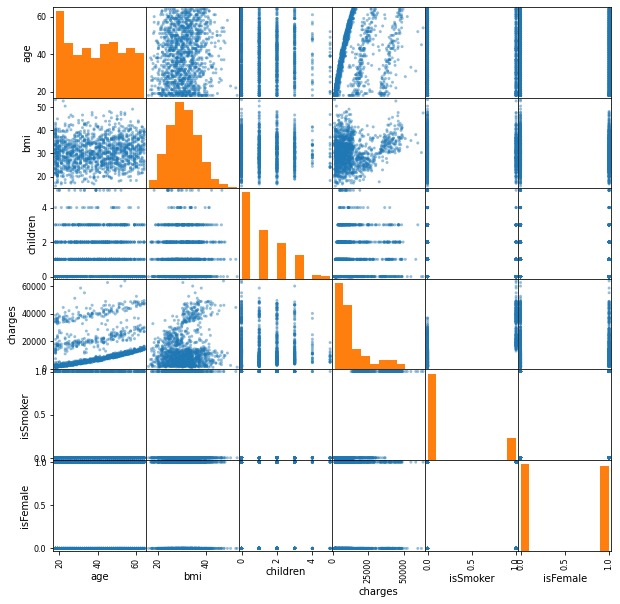

In [19]:
from pandas.plotting import scatter_matrix

# mostramos la scatter matrix por pantalla
axs = scatter_matrix(pdf.drop(columns=['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']), figsize=(10, 10), alpha=0.47, hist_kwds={'color':'#ff7f0e'})               

Del grafico anterior, podemos observar algunas cuestiones interesantes, pareciera haber un relación de 3 grupos o 3 cuartiles entre edad y charges, y entre bmi y charges, lo cual estaría indicando lo mismo que veiamos en la matriz de correlación. También podemos ver que los valores de charges son mas altos para los fumadores.

###6. Visualizacion del dataset

Intentaremos aplicar PCA para reducir la dimensionalidad de nuestras features a 2, e intentar confirmar efectivamente, si existe o no algun patron entre nuestros datos y la variable objectivo.

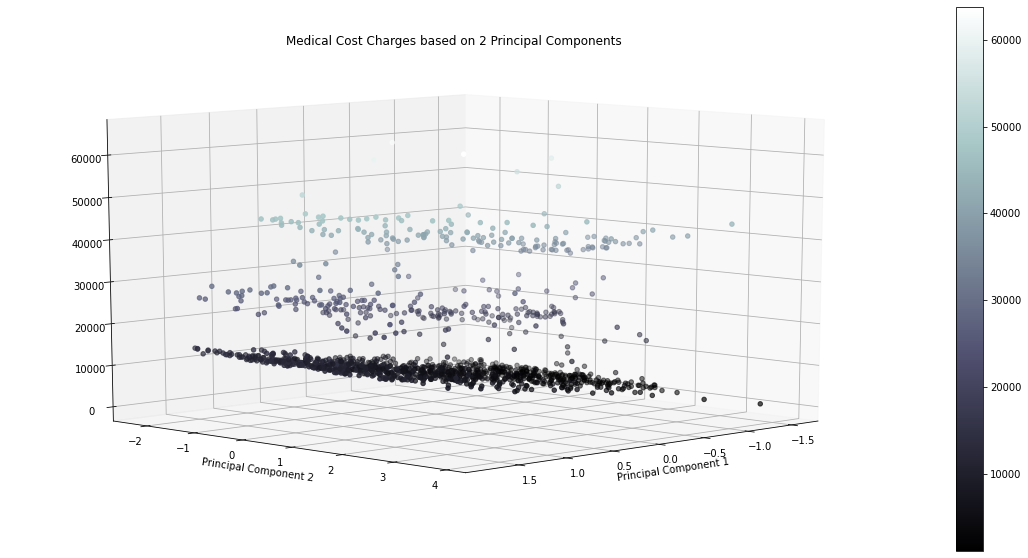

In [20]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2, whiten=True).fit(X_df)
pca = pca_model.transform(X_df)

fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection='3d')
scat = ax.scatter(pca[:, 0], pca[:, 1], y,  c=y, cmap="bone")

plt.colorbar(scat)
plt.grid(True)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Medical Cost Charges based on 2 Principal Components')
ax.view_init(10, 45)
plt.show()


A partir del grafico podemos observar que el analisis con PCA, nos permite ver que nuestros ejemplos, claramente estan agrupados en 3 grandes grupos, segun el **charges** que la compañia de seguro les esta cobrando.

En principio podriamos pensar que la division esta dada por el grupo etario al que pertenecen, el bmi y si es o no fumador, como veniamos sospechando ateriormente, pero no tenemos forma de asegurarlo.

Ademas, se puede observar que el grupo inferior es el que mas data points contiene y el que menos paga de prima, y a medida que incrementamos el nivel del costo del seguro, los data points disminuyen. Lo cual podria corresponderse al mismo fenomeno que observamos antes, que hay mas cantidad de personas en el rango 20/30, que de las que tienen mas de 30 años o mas de 40. 

Sin embargo, otra vez, no tenemos forma de saber existe un relacion entre la edad, o si es fumador o no, o alguna otra feature, solo intuir que la compañia de seguro pareciera estar segmentado a sus clientes en 3 grandes grupos de riesgo.

Esto ultimo podria indicarnos que tal vez un regresor lineal, no sea la mejor opcion para predecir nuestro dataset, dado que en la figura necesitariamos de 3 hiperplanos para poder estimar adecuadamente cada uno de los datapoints

Por ultimo, aca tambien podemos observar algunos outliers, cuyo valor de prima se va bastante por encima del resto, por encima de los 45k, habria que tener en cuenta, y en caso de ser necesario, remover estos ejemplos que en principio estarian generando algo de ruido.

### 7. Particionar los datos

En esta parte haremos la división de nuestro dataset en conjuntos training, validation y test.

Para esto usaremos la función train_test_split que trae sklearn.

Para hacer la primer partición, nos pareció acorde partir en 80/20 inicialmente. 80% para training y 20% para validación y test. En la segunda partición, tomamos el 20% en cuestión y partimos 50/50 entre validación y test. 

In [21]:
from sklearn.model_selection import train_test_split

# 80/20 => 80 para train y 20 para validacion y test(10 y 10)
X_train, X_testval, y_train, y_testval = train_test_split(X, y, test_size=0.2, random_state=1)
# de los 20 que guardamos, nos quedamos 50/50 para validacion y test
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.5, random_state=0)

print('=========================================')
print('PARTITIONED MEDICAL COST PERSONAL DATASET')
print('----------------------------')
print('Training set size: {}'.format(X_train.shape))
print('----------------------------')
print('Validation set size: {}'.format(X_val.shape))
print('----------------------------')
print('Test set size: {}'.format(X_test.shape))
print('=========================================')

PARTITIONED MEDICAL COST PERSONAL DATASET
----------------------------
Training set size: (1070, 9)
----------------------------
Validation set size: (134, 9)
----------------------------
Test set size: (134, 9)


A continuación, estudiaremos la distribución de nuestra variable objetivo en cada conjunto. Esto se hace para poder garantizar que estamos entrenando el algoritmo con distribuciones representativas. Utilizaremos un histograma para comparar las distribuciones. 

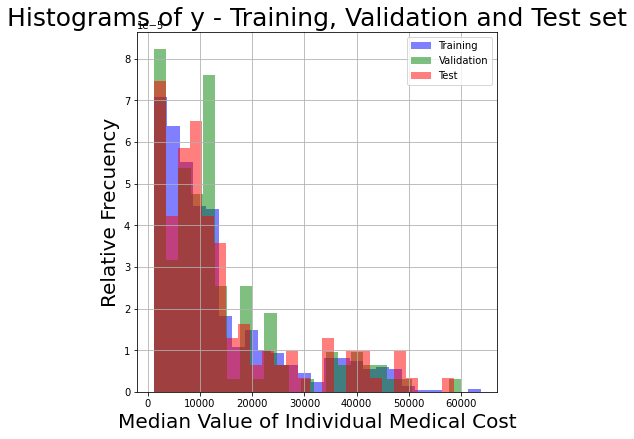

In [22]:
from matplotlib import pyplot as plt

relative_frecuency = True
n_bins = 25

fig = plt.figure(figsize=(5,5))
ax = fig.add_axes([0,0,1,1])

# hacemos histogramas de 25 baldes para los datos de entrenamiento, validación y
# test, en los colores azul (b), verde (g) y rojo (r), con cierta transparencia 
ax.hist(y_train, n_bins, density=relative_frecuency, facecolor='b', alpha=0.5)
ax.hist(y_val, n_bins, density=relative_frecuency, facecolor='g', alpha=0.5)
ax.hist(y_test, n_bins, density=relative_frecuency, facecolor='r', alpha=0.5)

ax.set_xlabel('Median Value of Individual Medical Cost', color='black', size=20)
if relative_frecuency:
  ax.set_ylabel('Relative Frecuency', color='black',size=20)
else:
  ax.set_ylable('Absulte Frecuency', color='black',size=20) 

ax.tick_params(axis='both', colors='black')
ax.set_title('Histograms of y - Training, Validation and Test set',color='black',size=25)          
ax.legend(['Training', 'Validation', 'Test'])
ax.grid(True)
plt.show()

Vemos que los perfiles de curvas son mas o menos similares y que los valores más frecuentes están entre 0 y 10.000.

Elegimos usar frecuencia relativa (relative_frecuency = True) ya que los datos de entrenamiento son bastante mas grandes que las otras dos particiones, entonces, si usásemos frecuencia absoluta no absorveríamos la variabilidad producto de las diferencias de tamaño. 

### 8. Normalización de los Datos

Evaluamos los rangos para ver si hay que normalizar y estandarizar los datos. 

In [23]:
print('========================')
print('TRAINING SET STATISTICS:')
print('Min values: {}'.format(np.min(X_train, axis=0)))
print('Max values: {}'.format(np.max(X_train, axis=0)))
print('========================')

TRAINING SET STATISTICS:
Min values: [18.   15.96  0.    0.    0.    0.    0.    0.    0.  ]
Max values: [64.   53.13  5.    1.    1.    1.    1.    1.    1.  ]


Podemos ver que existen rangos diferentes entre las features. 

Lo mejor será aplicar un feature scaling para que todas las features vivan en el intervalo [0,1].

Aplicaremos la siguiente ecuación sobre cada columna:

$ x_\text{normalizado} = \frac{x - x_\text{min}}{x_\text{max} - x_\text{min}}$

No la aplicaremos manualmente sino que lo haremos através de la función MinMaxScaler que trae sklearn. 


In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_norm = scaler.fit_transform(X_train)

print('========================')
print('NORMALIZED TRAINING SET:')
print('Min values: {}'.format(np.min(X_train_norm, axis=0)))
print('Max values: {}'.format(np.max(X_train_norm, axis=0)))
print('========================')

NORMALIZED TRAINING SET:
Min values: [0. 0. 0. 0. 0. 0. 0. 0. 0.]
Max values: [1. 1. 1. 1. 1. 1. 1. 1. 1.]


Podemos ver entonces que ahora las features en los datos de training toman todas valores entre 0 y 1.

Todos los datos deben vivir en el mismo espacio de características(o sino los modelos entrenados no serán capaces de trabajar), por lo tanto, tenemos que normalizar los datos de Validación y de Test.

Para ellos usaremos el mismo scaler creado y fiteado con los datos de training.

In [25]:
# normalizamos los datos de validación con el scaler
X_val_norm = scaler.transform(X_val)

# normalizamos los datos de test con el scaler
X_test_norm = scaler.transform(X_test)

# Entrenamiento

Inicialmente entrenaremos un regresor lineal básico, no con el objectivo de evaluar su performance, sino con el de ver desde dónde partimos y poder ver cuánto podemos mejorar la performance de éste. Para esto, utilizaremos modelos lineales más sofisticados, como Ridge y Lasso, y modeos no lineales como Random Forest. 

Finalmente, evaluaremos cuál de todos los modelos analizados ofrece los mejores resultados. 
Para la evaluación de los mismos, tenemos una serie de métricas útiles. Además de accuracy, podremos usar también MSE y MAE. En este caso, eligiremos usar MSE por una cuestión: queremos penalizar las distancias mas largas. Usaremos una modificación del MSE, el RMSE, para poder conservar la unidad (dólares, y no dólares al cuadrado). 


### Regresor Lineal

El modelo que aprenderemos tiene una serie de parámetros $\theta_i$ que, combinados linealmente con cada feature $x_i$, permiten obtener la estimación de la variable objetivo $\hat{y}$:

$\hat{y} = \theta_1 · x_1 + \theta_2 · x_2 + ... + \theta_d · x_d = \sum_{i=1}^d \theta_i · x_i$

Según la cantidad de features (dimensiones), la ecuación representa Rectas (1D), planos (2D) o hiperplanos (3D o más) como combinaciones lineales de variables y pesos. Por eso decimos que el modelo de regresión lineal sirve para ajustar / predecir datos que son lineales respecto a la variable objetivo.

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# creamos el objeto de la clase LinearRegression con fit_intercept=True
# esto significa que el hiperplano no partirá desde el origen de cordenas sino que tendrá
# una ordenada al origen acorde a los datos.
linear_regression_model = LinearRegression(fit_intercept=True)
# entrenamos el regresor con los datos de entrenamiento normalizados
linear_regression_model.fit(X_train_norm, y_train)

# predecimos un hiperplano pasando el regresor sobre los mismos datos de entrenamiento
y_hat_train = linear_regression_model.predict(X_train_norm)
# generamos métricas
mse = mean_squared_error(y_train, y_hat_train)
rmse = mean_squared_error(y_train, y_hat_train, squared=False)
mae = mean_absolute_error(y_train, y_hat_train)

print('===============================')
print('SIMPLE LINEAR REGRESSION MODEL:')
#print('MSE in training data = {:.4f}'.format(mse))
print('RMSE in training data = {:.4f}'.format(rmse))
#print('MAE in training data = {:.4f}'.format(mae))
print('Score in training data = {:.4f}'.format(linear_regression_model.score(X_train_norm, y_train)))
print('===============================')

SIMPLE LINEAR REGRESSION MODEL:
RMSE in training data = 6065.2911
Score in training data = 0.7478


In [27]:
# hacemos una predicción tomando el resto de los datos para ver cómo se comportan las métricas
X_testval_norm = scaler.transform(X_testval)
y_hat_testval = linear_regression_model.predict(X_testval_norm)
mse = mean_squared_error(y_testval, y_hat_testval)
rmse = mean_squared_error(y_testval, y_hat_testval, squared=False)
mae = mean_absolute_error(y_testval, y_hat_testval)

print('===============================')
print('SIMPLE LINEAR REGRESSION MODEL:')
#print('MSE in test and validation data = {:.4f}'.format(mse))
print('RMSE in test and validation data = {:.4f}'.format(rmse))
#print('MAE in test and validation data = {:.4f}'.format(mae))
print('Score in training data = {:.4f}'.format(linear_regression_model.score(X_testval_norm, y_testval)))
print('===============================')

SIMPLE LINEAR REGRESSION MODEL:
RMSE in test and validation data = 5956.4547
Score in training data = 0.7623


### Regresión Ridge 

El modelo de regresión lineal tradicional es susceptible a sufrir de overfitting, ya que no tiene nada que lo ayude a controlar que no suceda.

El modelo de regresión ridge introduce un término adicional a la función de error que se optimiza durante el entrenamiento (un **regularizador**) que penaliza que el modelo se centre demasiado en utilizar pocas features.

Para controlar el balance entre el regularizador y el error, se utiliza un parámetro $\lambda \geq 0$ (en ```sklearn```, $\alpha$) que indica la "fuerza" del regularizador: cuanto más alto es, más atención se le presta al regularizador y menos a la función de error; cuanto más cercano a 0 es, más atención le presta a la función de error y menos al regularizador (más se parece al modelo clásico de regresión).

Vamos a entrenar ahora modelos de Ridge Regression utilizando ocho valores posibles de $\alpha$.

In [28]:
from sklearn.linear_model import Ridge

alpha_values = [0.0001, 0.001, 0.01, 1.0, 2.5, 10.0, 100.0, 10000]
ridge_models = []

print('Model comparison on the TRAINING SET:')
print('=====================================')

for alpha in alpha_values:
  # inicializamos un modelo de Ridge regression
  ridge_model = Ridge(alpha=alpha, fit_intercept=True, normalize=False)
  # lo entrenamos
  ridge_model.fit(X_train_norm, y_train)
  ridge_models.append(ridge_model)
  # y lo evaluamos sobre los datos de training utilizando MSE
  y_hat_train = ridge_model.predict(X_train_norm)
  current_mse = mean_squared_error(y_train,  y_hat_train)
  current_rmse = mean_squared_error(y_train,  y_hat_train, squared=False)
  current_mae = mean_absolute_error(y_train,  y_hat_train)
  #print('Ridge with alpha: {:.4f} \t MSE = {:.4f} \t MAE = {:.4f}'.format(alpha, current_mse, current_mae))
  print('Ridge with alpha: {:.4f} \t RMSE = {:.4f}'.format(alpha, current_rmse))

Model comparison on the TRAINING SET:
Ridge with alpha: 0.0001 	 RMSE = 6065.2911
Ridge with alpha: 0.0010 	 RMSE = 6065.2911
Ridge with alpha: 0.0100 	 RMSE = 6065.2912
Ridge with alpha: 1.0000 	 RMSE = 6066.0135
Ridge with alpha: 2.5000 	 RMSE = 6069.5347
Ridge with alpha: 10.0000 	 RMSE = 6117.8224
Ridge with alpha: 100.0000 	 RMSE = 7402.3563
Ridge with alpha: 10000.0000 	 RMSE = 11934.3207


In [29]:
#print('Model comparison in terms of MSE & MAE on the VALIDATION SET')
print('Model comparison in terms of RMSE on the VALIDATION SET')
print('============================================================')
mse_ridge_regression = np.zeros(len(alpha_values))
rmse_ridge_regression = np.zeros(len(alpha_values))
mae_ridge_regression = np.zeros(len(alpha_values))

for i in range(len(ridge_models)):
  # y lo evaluamos sobre los datos de validación utilizando MSE
  y_hat_val = ridge_models[i].predict(X_val_norm)
  current_mse = mean_squared_error(y_val, y_hat_val)
  current_rmse = mean_squared_error(y_val, y_hat_val, squared=False)
  current_mae = mean_absolute_error(y_val, y_hat_val)
  mse_ridge_regression[i] = current_mse
  rmse_ridge_regression[i] = current_rmse
  mae_ridge_regression[i] = current_mae
  #print('Ridge with alpha: {:.4f} \t MSE = {:.4f} \t MAE = {:.4f}'.format(alpha_values[i], current_mse, current_mae))
  print('Ridge with alpha: {:.4f} \t RMSE = {:.4f}'.format(alpha_values[i], current_rmse))

# identificamos el valor de alpha que nos da mejores resultados
best_mse_alpha_ridge_idx = np.argmin(mse_ridge_regression)
best_mse_alpha_ridge = alpha_values[best_mse_alpha_ridge_idx]
best_mse_ridge = mse_ridge_regression[best_mse_alpha_ridge_idx]
best_mse_ridge_model = ridge_models[best_mse_alpha_ridge_idx]

best_rmse_alpha_ridge_idx = np.argmin(rmse_ridge_regression)
best_rmse_alpha_ridge = alpha_values[best_rmse_alpha_ridge_idx]
best_rmse_ridge = rmse_ridge_regression[best_rmse_alpha_ridge_idx]
best_rmse_ridge_model = ridge_models[best_rmse_alpha_ridge_idx]

best_mae_alpha_ridge_idx = np.argmin(mae_ridge_regression)
best_mae_alpha_ridge = alpha_values[best_mae_alpha_ridge_idx]
best_mae_ridge = mae_ridge_regression[best_mae_alpha_ridge_idx]
best_mae_ridge_model = ridge_models[best_mae_alpha_ridge_idx]

print('============================================================')
#print('Best Ridge regression model: alpha={} - MSE = {:.4f}'.format(best_mse_alpha_ridge, best_mse_ridge))
print('Best Ridge regression model: alpha={} - RMSE = {:.4f}'.format(best_rmse_alpha_ridge, best_rmse_ridge))

Model comparison in terms of RMSE on the VALIDATION SET
Ridge with alpha: 0.0001 	 RMSE = 5566.2335
Ridge with alpha: 0.0010 	 RMSE = 5566.2409
Ridge with alpha: 0.0100 	 RMSE = 5566.3145
Ridge with alpha: 1.0000 	 RMSE = 5574.7961
Ridge with alpha: 2.5000 	 RMSE = 5588.9371
Ridge with alpha: 10.0000 	 RMSE = 5675.6739
Ridge with alpha: 100.0000 	 RMSE = 7084.8074
Ridge with alpha: 10000.0000 	 RMSE = 11875.5215
Best Ridge regression model: alpha=0.0001 - RMSE = 5566.2335


### Regresión Lasso

El regularizador en el modelo de Ridge Regression intenta que le prestemos atención a todas las features más o menos igual. Sin embargo, si entre las features hay algunas que no sirven demasiado puede ocurrir que la performance termine siendo peor.

Este modelo de regresión, LASSO, nos permitirá aprender un vector de pesos ralo, a través de un regularizador con un peso $\lambda$ (o $\alpha$), con un rol similar al del model de Ridge Regression. 

Vamos a entrenar un único modelo Lasso y comparar los parámetros que aprende con su equivalente Ridge Regression.

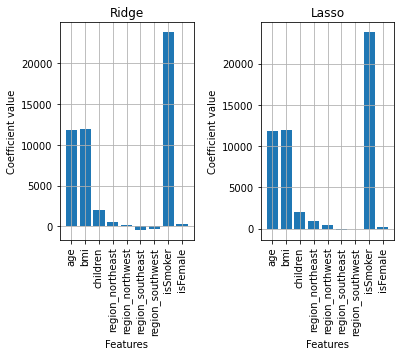

In [30]:
from sklearn.linear_model import Lasso

# inicializamos listas de modelos a entrenar y sus nombres
models = [Ridge(alpha=best_rmse_alpha_ridge, fit_intercept=True), # Ridge Regression
          Lasso(alpha=best_rmse_alpha_ridge, fit_intercept=True)] # Lasso
model_names = ['Ridge', 'Lasso']

# inicializamos los gráficos
fig, axes = plt.subplots(1, len(models))
plt.subplots_adjust(wspace=0.5)
# y entrenamos los modelos
i=0
for model in models:
  # entrenamos el modelo
  model.fit(X_train_norm, y_train)
  # sacamos los coeficientes
  theta=model.coef_
  # mostramos graficamente los pesos
  axes[i].bar(np.arange(np.squeeze(theta.size)), np.squeeze(theta))
  axes[i].set_title(model_names[i])
  axes[i].set_xlabel('Features')
  axes[i].set_ylabel('Coefficient value')
  axes[i].set_xticks(np.arange(theta.size))
  axes[i].set_xticklabels(labels=X_df.columns,rotation = 90)
  axes[i].grid(True)
  i = i+1
plt.show()


Podemos ver que en el caso de LASSO, el modelo tiene  más parámetros en 0. De alguna manera, estamos haciendo feature selection al mismo tiempo que entrenamos. Esto en algunos casos puede ser muy agresivo, y en otros ayudar. 

Hagamos entonces como antes, usando diferentes valores para $\lambda$ (o $\alpha$).

In [31]:
#print('Model comparison in terms of MSE & MAE on the VALIDATION SET')
print('Model comparison in terms of RMSE on the VALIDATION SET')
print('============================================================')
# valores de MSE y MAE obtenidos por cada modelo
mse_lasso_regression = np.zeros(len(alpha_values))
rmse_lasso_regression = np.zeros(len(alpha_values))
mae_lasso_regression = np.zeros(len(alpha_values))
# lista donde guardar los modelos LASSO
lasso_models = []

i=0
for alpha in alpha_values:
  # inicializamos un modelo LASSO
  lasso_model = Lasso(alpha=alpha, fit_intercept=True, normalize=False)
  lasso_models.append(lasso_model)
  # lo entrenamos
  lasso_model.fit(X_train_norm, y_train)
  # y lo evaluamos sobre los datos de validación
  y_hat_val = lasso_model.predict(X_val_norm)
  current_mse = mean_squared_error(y_val, y_hat_val)
  current_rmse = mean_squared_error(y_val, y_hat_val, squared=False)
  current_mae = mean_absolute_error(y_val, y_hat_val)
  mse_lasso_regression[i] = current_mse
  rmse_lasso_regression[i] = current_rmse
  mae_lasso_regression[i] = current_mae
  #print('LASSO with alpha: {:.4f} \t MSE = {:.4f} \t MAE = {:.4f}'.format(alpha_values[i], current_mse, current_mae))
  print('LASSO with alpha: {:.4f} \t RMSE = {:.4f}'.format(alpha_values[i], current_rmse))
  i = i+1

# identificamos el valor de alpha que nos da mejores resultados
# identificamos el valor de alpha que nos da mejores resultados
best_mse_alpha_lasso_idx = np.argmin(mse_lasso_regression)
best_mse_alpha_lasso = alpha_values[best_mse_alpha_lasso_idx]
best_mse_lasso = mse_lasso_regression[best_mse_alpha_lasso_idx]
best_mse_lasso_model = lasso_models[best_mse_alpha_lasso_idx]

best_rmse_alpha_lasso_idx = np.argmin(rmse_lasso_regression)
best_rmse_alpha_lasso = alpha_values[best_rmse_alpha_lasso_idx]
best_rmse_lasso = rmse_lasso_regression[best_rmse_alpha_lasso_idx]
best_rmse_lasso_model = lasso_models[best_rmse_alpha_lasso_idx]

best_mae_alpha_lasso_idx = np.argmin(mae_lasso_regression)
best_mae_alpha_lasso = alpha_values[best_mae_alpha_lasso_idx]
best_mae_lasso = mae_lasso_regression[best_mae_alpha_lasso_idx]
best_mae_lasso_model = lasso_models[best_mae_alpha_lasso_idx]

print('============================================================')
#print('Best Lasso regression model: alpha={} - MSE = {:.4f}'.format(best_mse_alpha_lasso, best_mse_lasso))
print('Best Lasso regression model: alpha={} - RMSE = {:.4f}'.format(best_rmse_alpha_lasso, best_rmse_lasso))

Model comparison in terms of RMSE on the VALIDATION SET
LASSO with alpha: 0.0001 	 RMSE = 5566.2328
LASSO with alpha: 0.0010 	 RMSE = 5566.2339
LASSO with alpha: 0.0100 	 RMSE = 5566.2451
LASSO with alpha: 1.0000 	 RMSE = 5567.4840
LASSO with alpha: 2.5000 	 RMSE = 5569.4030
LASSO with alpha: 10.0000 	 RMSE = 5579.7410
LASSO with alpha: 100.0000 	 RMSE = 5761.9923
LASSO with alpha: 10000.0000 	 RMSE = 12026.7818
Best Lasso regression model: alpha=0.0001 - RMSE = 5566.2328


### Regresión Random Forest 

Random Forest es un modelo de machine learning basado en ensambles. Los modelos basados en ensambles integran las respuestas de varios submodelos para producir una respuesta final. En el caso de RF, se cuenta con varios árboles de decisión entrenados a partir de particiones aleatorias de los datos de entrenamientos y subconjuntos de características.

Vamos a hacer una primera prueba del método de RF regression usando diferentes cantidades de árboles, y evaluando cada uno sobre los datos de validación. También vamos a tomar el tiempo que demora cada entrenamiento y cada ejecución de validación, para ver cómo afecta el número de árboles al costo computacional del algoritmo.

In [32]:
from sklearn.ensemble import RandomForestRegressor
import time

# numero de arboles
num_trees = [3, 5, 10, 50, 100, 200, 300, 400, 500, 1000]

#numero de trees
total_trees = len(num_trees);
# tiempos de entrenamiento y prediccion
training_time = np.zeros(total_trees)
prediction_time = np.zeros(total_trees)
# inicializamos una lista de modelos
rf_models = []

# arreglo para ir guardando los valores de MSE y MAE
mse_rf_regression = np.zeros(total_trees)
rmse_rf_regression = np.zeros(total_trees)
mae_rf_regression = np.zeros(total_trees)

# iteramos por cada numero de arboles
i = 0
print('RF Regression')
print('=============')
for N in num_trees:  
  # definimos el modelo
  rf_model = RandomForestRegressor(n_estimators=N, random_state=0)
  # lo entrenamos sobre los datos de entrenamiento, midiendo el tiempo que lleva
  start_time = time.time()
  rf_model.fit(X_train_norm, np.squeeze(y_train))
  training_time[i] = time.time() - start_time
  rf_models.append(rf_model)
  # predecimos sobre los datos de validacion, registrando el tiempo que lleva
  start_time = time.time()
  y_hat_val = rf_model.predict(X_val)
  prediction_time[i] = time.time() - start_time
  # evaluamos el MSE y MAE
  mse_rf_regression[i] = mean_squared_error(y_val, y_hat_val)
  rmse_rf_regression[i] = mean_squared_error(y_val, y_hat_val, squared=False)
  mae_rf_regression[i] = mean_absolute_error(y_val, y_hat_val)  
  # imprimimos las estadisticas
  #print('N = {:<6} MSE = {:.4f} \t MAE = {:.4f} \t Train Time = {:.4f} s \t Pred Time = {:.4f} s'.format(N, mse_rf_regression[i], mae_rf_regression[i], training_time[i], prediction_time[i]))
  print('N = {:<6} \t RMSE = {:.4f} \t Train Time = {:.4f} s \t Pred Time = {:.4f} s'.format(N, rmse_rf_regression[i], training_time[i], prediction_time[i]))  
  i = i + 1

RF Regression
N = 3      	 RMSE = 17366.2725 	 Train Time = 0.0145 s 	 Pred Time = 0.0008 s
N = 5      	 RMSE = 17489.8270 	 Train Time = 0.0186 s 	 Pred Time = 0.0008 s
N = 10     	 RMSE = 16790.1651 	 Train Time = 0.0392 s 	 Pred Time = 0.0012 s
N = 50     	 RMSE = 17929.7225 	 Train Time = 0.1775 s 	 Pred Time = 0.0038 s
N = 100    	 RMSE = 18081.4627 	 Train Time = 0.3530 s 	 Pred Time = 0.0075 s
N = 200    	 RMSE = 17943.3639 	 Train Time = 0.6740 s 	 Pred Time = 0.0141 s
N = 300    	 RMSE = 18124.9584 	 Train Time = 1.0530 s 	 Pred Time = 0.0206 s
N = 400    	 RMSE = 17977.0149 	 Train Time = 1.3562 s 	 Pred Time = 0.0288 s
N = 500    	 RMSE = 18003.9817 	 Train Time = 1.7124 s 	 Pred Time = 0.0342 s
N = 1000   	 RMSE = 17960.2081 	 Train Time = 3.4674 s 	 Pred Time = 0.0776 s


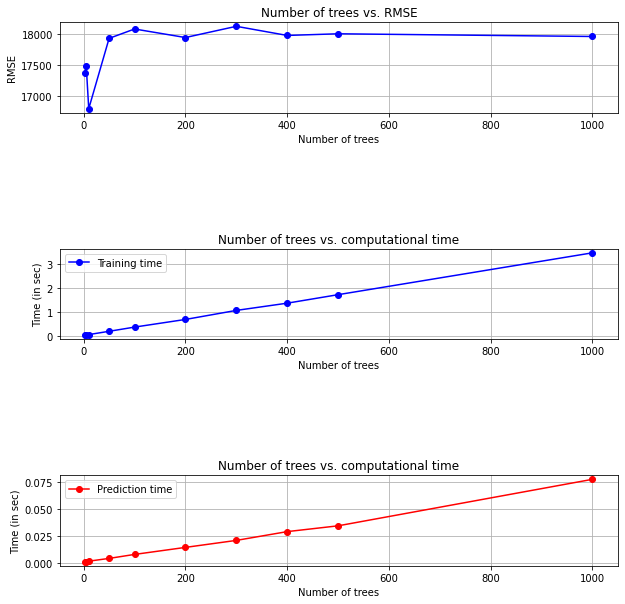

In [33]:

# inicializamos los gráficos
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=1.5)
# mostramos graficamente la evolución del MSE o MAE
#axes[0].plot(np.asarray(num_trees), mse_rf_regression, '-bo')
axes[0].plot(np.asarray(num_trees), rmse_rf_regression, '-bo')
#axes[0].set_title('Number of trees vs. MSE')
axes[0].set_title('Number of trees vs. RMSE')
axes[0].set_xlabel('Number of trees')
#axes[0].set_ylabel('MSE')
axes[0].set_ylabel('RMSE')
axes[0].grid(True)
# y el tiempo en entrenamiento
axes[1].plot(np.asarray(num_trees), training_time, '-bo')
axes[1].legend(['Training time'])
axes[1].set_title('Number of trees vs. computational time')
axes[1].set_xlabel('Number of trees')
axes[1].set_ylabel('Time (in sec)')
axes[1].grid(True)
# y en validacion
axes[2].plot(np.asarray(num_trees), prediction_time, '-ro')
axes[2].legend(['Prediction time'])
axes[2].set_title('Number of trees vs. computational time')
axes[2].set_xlabel('Number of trees')
axes[2].set_ylabel('Time (in sec)')
axes[2].grid(True)
plt.show()

Como conclusión de los gráficos podemos ver que:

- el RMSE es bastante estable (ronda 18.000), salvo en 10 árboles, que encuentra su valor mínimo (poco menos de 17.000)

- el tiempo crece casi linealmente en función de la cantidad de árboles que utilicemos

#### Importancia de las features segun Random Forest

In [34]:
# identificamos el mejor modelo
best_mse_n_rf_idx = np.argmin(mse_rf_regression)
best_mse_n_rf = num_trees[best_mse_n_rf_idx]
best_mse_rf = mse_rf_regression[best_mse_n_rf_idx]
best_mse_rf_model = rf_models[best_mse_n_rf_idx]

best_rmse_n_rf_idx = np.argmin(rmse_rf_regression)
best_rmse_n_rf = num_trees[best_rmse_n_rf_idx]
best_rmse_rf = rmse_rf_regression[best_rmse_n_rf_idx]
best_rmse_rf_model = rf_models[best_rmse_n_rf_idx]

best_mae_n_rf_idx = np.argmin(mae_rf_regression)
best_mae_n_rf = num_trees[best_mae_n_rf_idx]
best_mae_rf = mae_rf_regression[best_mae_n_rf_idx]
best_mae_rf_model = rf_models[best_mae_n_rf_idx]


print('=============================')
#print('Best RF regression model: N={} - MSE = {:.4f}'.format(best_mse_n_rf, best_mse_rf))
print('Best RF regression model: N={} - RMSE = {:.4f}'.format(best_rmse_n_rf, best_rmse_rf))

Best RF regression model: N=10 - RMSE = 16790.1651


FEATURE IMPORTANCE RANKING
1.isSmoker(0.624291)
2.bmi(0.203407)
3.age(0.132417)
4.children(0.017293)
5.region_northeast(0.006003)
6.region_northwest(0.004950)
7.region_southeast(0.003909)
8.isFemale(0.003886)
9.region_southwest(0.003844)


<BarContainer object of 9 artists>

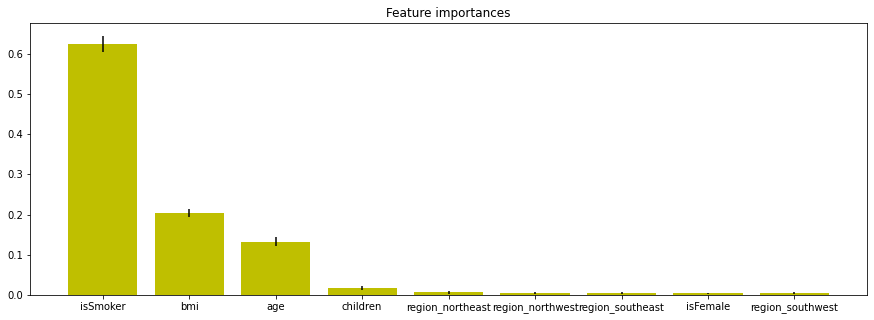

In [35]:
print('FEATURE IMPORTANCE RANKING')
print('==========================')

importances = best_mse_rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_mse_rf_model.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
variables = ['age', 'sex', 'bmi', 'children','smoker', 'region']
importance_list = []
for f in range(X_df.shape[1]):
    variable = X_df.columns[indices[f]]
    importance_list.append(variable)
    print("%d.%s(%f)" % (f + 1, variable, importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15, 5))
plt.title("Feature importances")
plt.bar(importance_list, importances[indices], color="y", yerr=std[indices], align="center")

Podemos observar lo que intuiamos al comienzo y que ya nos habian confirmado los coeficientes del lasso y ridge, y es que la features smoker, bmi y edad son las que mayor incidencia tienen en el costo del seguro

# Evaluaciones

#### RMSE y Accuracy en el Validation set

In [36]:
print('Model comparison in terms of RMSE on the VALIDATION SET')
print('======================================================')
#print('Best Ridge regression model in the validation set: \t MSE_alpha={} \t MAE_alpha={} \t MSE={:.4f} \t MAE={:.4f}'.format(best_mse_alpha_ridge,best_mae_alpha_ridge, best_mse_ridge, best_mae_ridge))
print('Best Ridge regression model in the validation set: \t RMSE_alpha={} \t RMSE={:.4f}'.format(best_rmse_alpha_ridge, best_rmse_ridge))
#print('Best LASSO regression model in the validation set: \t MSE_alpha={} \t MAE_alpha={}  MSE={:.4f} \t MAE={:.4f}'.format(best_mse_alpha_lasso,best_mae_alpha_lasso, best_mse_lasso, best_mae_lasso))
print('Best LASSO regression model in the validation set: \t RMSE_alpha={} \t RMSE={:.4f}'.format(best_rmse_alpha_lasso, best_rmse_lasso))
#print('Best RF regression model in the validation set: \t MSE_T={} \t\t MAE_T={} \t MSE={:.4f} \t MAE={:.4f}'.format(best_mse_n_rf,best_mae_n_rf, best_mse_rf, best_mae_rf))
print('Best RF regression model in the validation set: \t RMSE_T={} \t\t RMSE={:.4f}'.format(best_rmse_n_rf, best_rmse_rf))

Model comparison in terms of RMSE on the VALIDATION SET
Best Ridge regression model in the validation set: 	 RMSE_alpha=0.0001 	 RMSE=5566.2335
Best LASSO regression model in the validation set: 	 RMSE_alpha=0.0001 	 RMSE=5566.2328
Best RF regression model in the validation set: 	 RMSE_T=10 		 RMSE=16790.1651


A priori a partir de la performance en el validation set, podemos observar que tanto ridge y lasso se comportan bastante similar, si bien Lasso pareciera un poco mejor, la difrencia no es significativa. Esto se debe a que tanto en ridge como en lasso, el mejor alpha fue 0.0001, que justamente lo que hace es hacer que la influencia del regularizador sea ínfima, generándose un modelo de regresión lineal puro.


Sin embargo, random forest, si pareciera tener un diferencia significativa, para peor, en relacion a los modelos lineales.

Intentemos observar el accuracy de cada uno de los modelos, para poder ver si podemos descifrar que esta sucediendo

In [37]:
#print(f'Best Ridge regression mse model accuracy in the validation set: {best_mse_ridge_model.score(X_val_norm, y_val):.4f}')
print(f'Best Ridge regression rmse model accuracy in the validation set: {best_rmse_ridge_model.score(X_val_norm, y_val):.4f}')
#print(f'Best Ridge regression mae model accuracy in the validation set: {best_mae_ridge_model.score(X_val_norm, y_val):.4f}')
print('')
#print(f'Best Lasso regression mse model accuracy in the validation set: {best_mse_lasso_model.score(X_val_norm, y_val):.4f}')
print(f'Best Lasso regression rmse model accuracy in the validation set: {best_rmse_lasso_model.score(X_val_norm, y_val):.4f}')
#print(f'Best Lasso regression mae model accuracy in the validation set: {best_mae_lasso_model.score(X_val_norm, y_val):.4f}')
print('')
#print(f'Best RF regression mse model accuracy in the validation set: {best_mse_rf_model.score(X_val_norm, y_val):.4f}')
print(f'Best RF regression rmse model accuracy in the validation set: {best_rmse_rf_model.score(X_val_norm, y_val):.4f}')
#print(f'Best RF regression mae model accuracy in the validation set: {best_mae_rf_model.score(X_val_norm, y_val):.4f}')

Best Ridge regression rmse model accuracy in the validation set: 0.7858

Best Lasso regression rmse model accuracy in the validation set: 0.7858

Best RF regression rmse model accuracy in the validation set: 0.8640


Si miramos el accuracy, vemos que en esta caso, Random Forest si performa mejor que los modelos lineales en terminos de accuracy, vemos un mejoria notoria en esta métrica.

Antes de tomar una decision final, veamos como perfoman los mejores 3 modelos, en con el conjunto de test.

#### RMSE y Accuracy en el Test set

In [38]:
#models = [best_mse_ridge_model, best_mse_lasso_model, best_mse_rf_model, best_mae_ridge_model, best_mae_lasso_model, best_mae_rf_model]
#names = ["Best MSE Ridge", "Best MSE Lasso", "Best MSE RF", "Best MAE Ridge", "Best MAE Lasso", "Best MAE RF"]
#metrics = [mean_squared_error, mean_squared_error, mean_squared_error, mean_absolute_error, mean_absolute_error, mean_absolute_error]
print('Model comparison in terms of RMSE on the TEST SET')
print('=================================================')
models = [best_rmse_ridge_model, best_rmse_lasso_model, best_rmse_rf_model]
names = ["Best RMSE Ridge", "Best RMSE Lasso", "Best RMSE RF"]
metrics = [mean_squared_error, mean_squared_error, mean_squared_error]
#models = [best_mae_ridge_model, best_mae_lasso_model, best_mae_rf_model]
#names = ["Best MAE Ridge", "Best MAE Lasso", "Best MAE RF"]
#metrics = [mean_absolute_error, mean_absolute_error, mean_absolute_error]

for i in range(len(models)):
  model = models[i]
  name = names[i] 
  metric = metrics[i] 
  y_hat_test = model.predict(X_test_norm)  
  # quitar squared=False en el caso de querer usar MSE o MAE
  print(f'{name: <5}:\t {metric(y_test, y_hat_test, squared=False):.4f} \t Accuracy: {model.score(X_test_norm, y_test): .4f}')


Model comparison in terms of RMSE on the TEST SET
Best RMSE Ridge:	 6322.6394 	 Accuracy:  0.7403
Best RMSE Lasso:	 6322.6387 	 Accuracy:  0.7403
Best RMSE RF:	 5466.5642 	 Accuracy:  0.8058


### Visualizacion de las predicciones del conjunto de testing

Al igual que el comienzo, aplicaremos PCA para reducir la dimensionalidad del conjunto de testing, en cada uno de los mejores modelos segun la metrica de RMSE, y graficaremos para cada modelo, los data point originales, usando el valor verdadero y usando el valor estimado. 

Si bien, no es seguro afirmar nada, a partir de esta visuzalizacion, dado que al aplicar PCA perderemos referencia de los data point, podremos intentar ver que tanto se asemejan la figuras, o que tan distantes esta lo que predecimos de lo real.


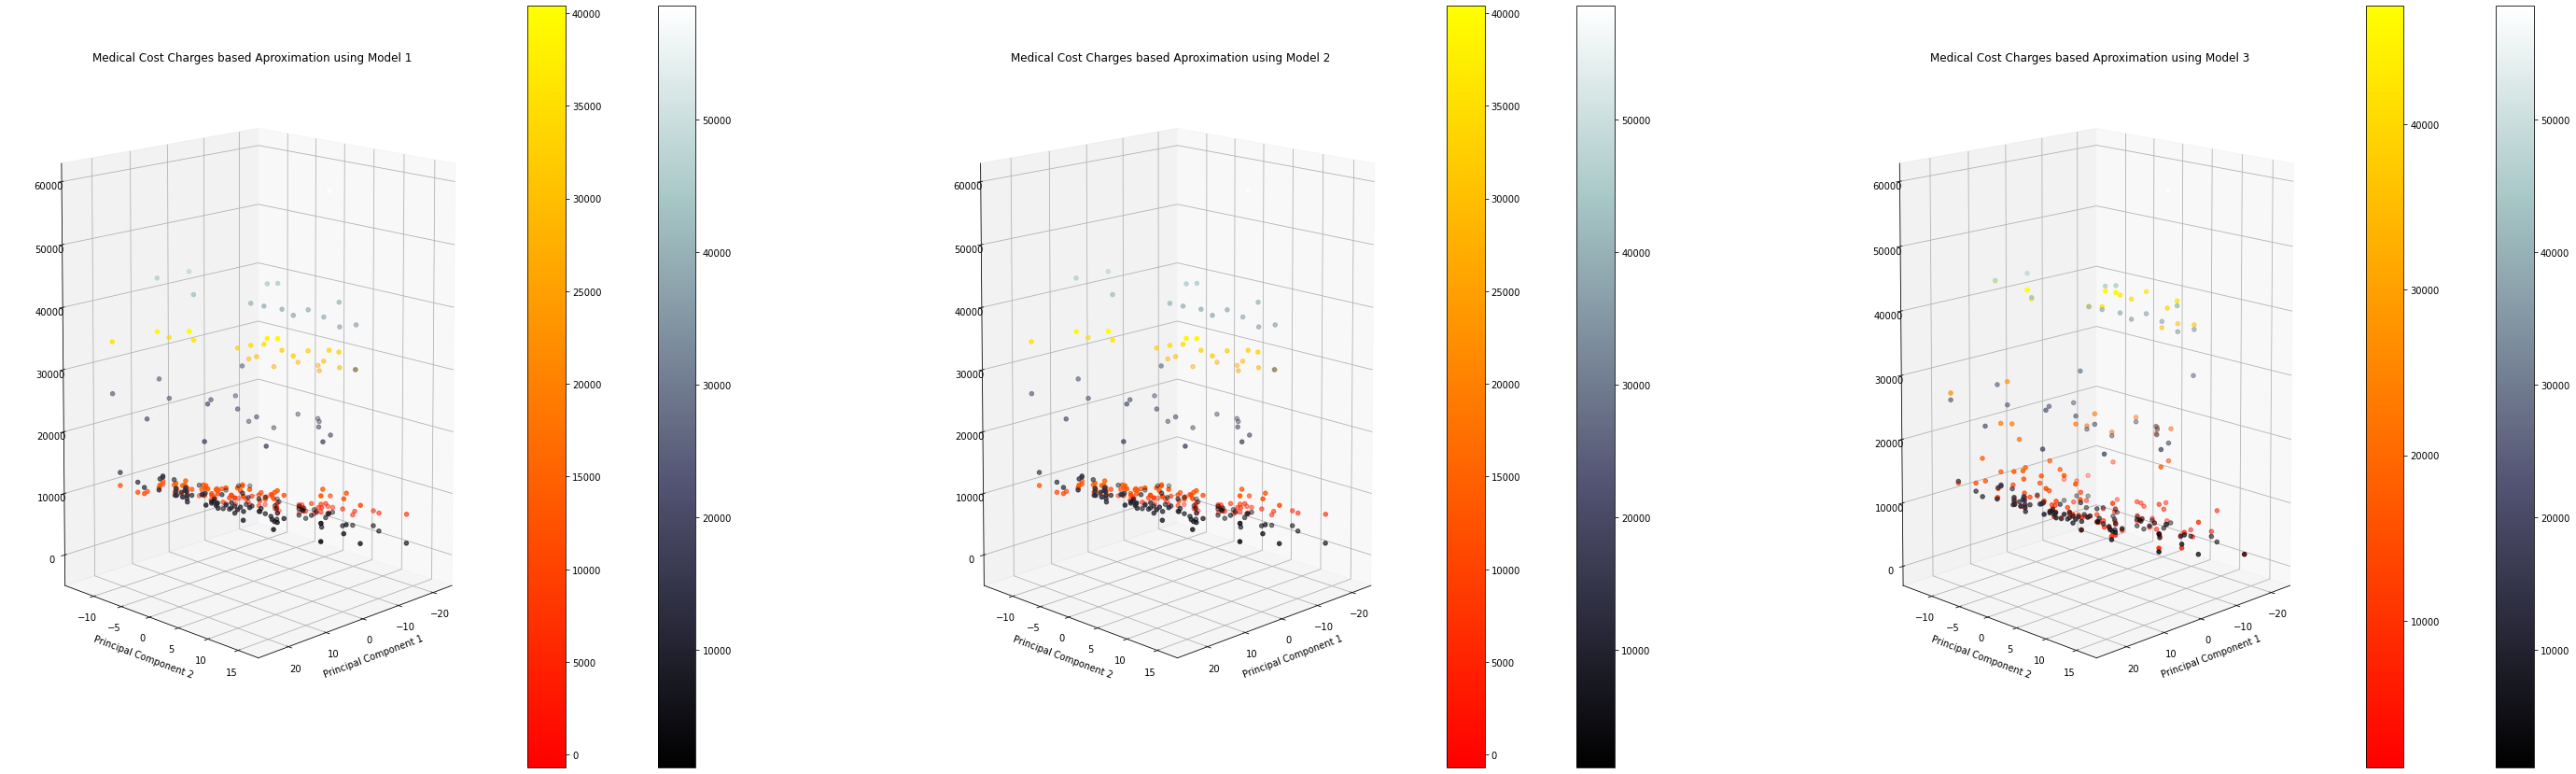

In [39]:
from matplotlib import gridspec

pca = PCA(n_components=2).fit_transform(X_test)

models = [best_rmse_ridge_model, best_rmse_lasso_model, best_rmse_rf_model]
subplot = 1
fig = plt.figure(figsize=(50, 15))
gs = gridspec.GridSpec(1, 3) 


for M in models:
  y_hat_test = M.predict(X_test_norm)
  ax = fig.add_subplot(gs[subplot - 1], projection='3d')  
  ax.view_init(10, 45)
  
  scat = ax.scatter(pca[:, 0], pca[:, 1], y_test,  c=y_test, cmap="bone")
  scat2 = ax.scatter(pca[:, 0], pca[:, 1], y_hat_test,  c=y_hat_test, cmap="autumn")

  fig.colorbar(scat)
  fig.colorbar(scat2)
  ax.set(xlabel='Principal Component 1', ylabel='Principal Component 2', title=f'Medical Cost Charges based Aproximation using Model {subplot}')  
  subplot = subplot+1

plt.show()

Como se puede ver en los graficos, a los modelos lineales, les cuesta generar predicciones en los 3 hiperplanos, sino que mas bien parecieran estar estimando algun tipo de funcion de umbral, e intentado aproximarse solo a 2 de los 3 hiperplanos. 

Tambien pareciera que los modelos lineales predicen mas o menos bien, los valores de variable objectivo chicos, pero comenten bastantes errores con valores grandes de variable objectivo, o dicho de otra manera, les cuesta predecir aquellos pacientes de mayor riesgo(pagan mas), que los que llevan una vida mas saludable. Mientras que random forest, pareciera hacerlo un poco mejor.

Sin embargo cuando observamos el grafico de random forest, podemos ver que las predicciones se observan en los 3 hiperplanos de forma equitativa.

Como se menciono anteriormente, si bien esto no nos da garantia, nos da un indicio de que tal vez, algun otro regresor no lineal pueda performar mejor que random forest

### Resultados finales

Al evaluar los modelos con el conjunto de testing, claramente podemos ver que random forest performa mejor en las 2 métricas (RMSE y Accuracy), en relación a los modelos lineales de ridge y lasso, algo que intuiamos del análisis de PCA realizado al comienzo, donde veíamos que los data points formaban 3 hiperplanos, algo dificil de alcanzar usando un regresor lineal, y que sí puede lograrse usando un regresor no lineal.

También podemos observar que el accuracy, si bien cae un poco, se mantiene dentro de los valores obtenidos en el validation set.

Otra observación interesante que podemos ver en el resultado de las métricas, es que los modelos lineales, poseen un mayor RMSE, lo cual nos indica que estarian comentiendo errores mayores para valores de variable objectivo grandes, en otras palabras, estaria comentiendo más errores para aquellos clientes de mayor riesgo. Algo sumamente importante a la hora de elegir un modelo, dado que tal vez sea mas conveniente que el modelo cometa errores en clientes sanos y no en clientes de riesgo.

Es necesario resaltar que en un dataset de 1338 muestras en las que el valor promedio de costo de seguro ronda los $13.270, un error promedio de 5500 dólares es un tanto elevado. Tal vez aumentando el dataset o sacando outliers, o usando algún otro modelo podamos aproximarnos un poco mejor.

Por último, podemos decir, que a pesar de que en los datos de validación, random forest no fue el mejor, optaremos por quedarnos con este, dado que demostró que un modelo no lineal se ajusta mejor a nuestro dataset y que además, nos permitió generalizar mucho mejor con datos nunca visto durante el entrenamiento.



# Extra

A modo adicional intentaremos usar algun otro regresor lineal no visto en clase, y ver cuanto mas podemos mejorar la performance en nuestro dataset

Para ellos el otro modelo que hemos elegido es un regresor que utiliza a Support Vector Machine junto con un kernel polinomico.

La idea sera trata de aproximar a travez de distintos polinomios y quedarnos con el mejor

In [40]:
from sklearn.svm import SVR

polynomial_models = []

for d in range(2, 10):
  svr_poly = SVR(kernel='poly', degree=d, C=100, gamma='auto', epsilon=.1, coef0=1)
  svr_poly.fit(X_train_norm, y_train.squeeze())  
  y_hat_val = svr_poly.predict(X_val_norm)    
  polynomial_models.append(svr_poly)  
  #print(f'SVR with degree: {d} \t MSE = {mean_squared_error(y_val,  y_hat_val):.4f}\t MAE = {mean_absolute_error(y_val,  y_hat_val):.4f} \t Accuracy: {model.score(X_val_norm, y_val): .4f}')
  print(f'SVR with degree: {d} \t RMSE = {mean_squared_error(y_val,  y_hat_val, squared=False):.4f}\t Accuracy: {model.score(X_val_norm, y_val): .4f}')

SVR with degree: 2 	 RMSE = 10498.4255	 Accuracy:  0.8640
SVR with degree: 3 	 RMSE = 9104.4291	 Accuracy:  0.8640
SVR with degree: 4 	 RMSE = 8109.2977	 Accuracy:  0.8640
SVR with degree: 5 	 RMSE = 7652.8032	 Accuracy:  0.8640
SVR with degree: 6 	 RMSE = 7353.3638	 Accuracy:  0.8640
SVR with degree: 7 	 RMSE = 7031.0612	 Accuracy:  0.8640
SVR with degree: 8 	 RMSE = 6746.4597	 Accuracy:  0.8640
SVR with degree: 9 	 RMSE = 6216.2741	 Accuracy:  0.8640


Recordemos que con random forest con el validation set obtuvimos:
  - **Best RMSE**:	 16790.1651 
  - **Accuracy**:  0.8640

De lo anterior podemos observar que la accuracy de SVR  es similar al Random Forest en el validation set, pero el RMSE nos da bastante mejor que Random Forest.


Dado lo anterior tomaremos como mejor modelo, el de grado 9 y veremos como se comportar SVR en el test set


## Evaluacion de SVR sobre el conjunto de test


In [41]:
svr_poly = polynomial_models[7]

y_hat_test = svr_poly.predict(X_test_norm)  
poly_mse = mean_squared_error(y_test,  y_hat_test)
poly_rmse = mean_squared_error(y_test,  y_hat_test, squared=False)
poly_mae = mean_absolute_error(y_test,  y_hat_test)
#print(f'MSE:{poly_mse:.4f}\t MAE:{poly_mae:.4f} \t Accuracy: {model.score(X_test_norm, y_test): .4f}')
print(f'RMSE:{poly_rmse:.4f}\t Accuracy: {model.score(X_test_norm, y_test): .4f}')

RMSE:7146.8439	 Accuracy:  0.8058



Recordemos que con random forest con el test set obtuvimos:
  - **Best RMSE**:	 5466.5642                    	 
  - **Accuracy**:    0.8058

Hemos podido probar que otro modelo no lineal, en este caso polinómico, nos permite obtener mejores resultados que los modelos lineales.

Sin embargo en este último caso, si bien la performance del SVR es bastante similar a la del random forest, podemos apreciar una caida en la performance (en el test set) en relación a los resultados obtenidos con el validation set, y tal vez esto nos este dando un indicio de que nuestro modelo de SVR esta algo overfitteado. 

##Veamos tambien que sucede si visualizamos las predicciones de SVR con PCA

[Text(0.5, 0, 'Principal Component 2'),
 Text(0.5, 0, 'Principal Component 1'),
 Text(0.5, 0.92, 'Medical Cost Charges based Aproximation using Model SVR')]

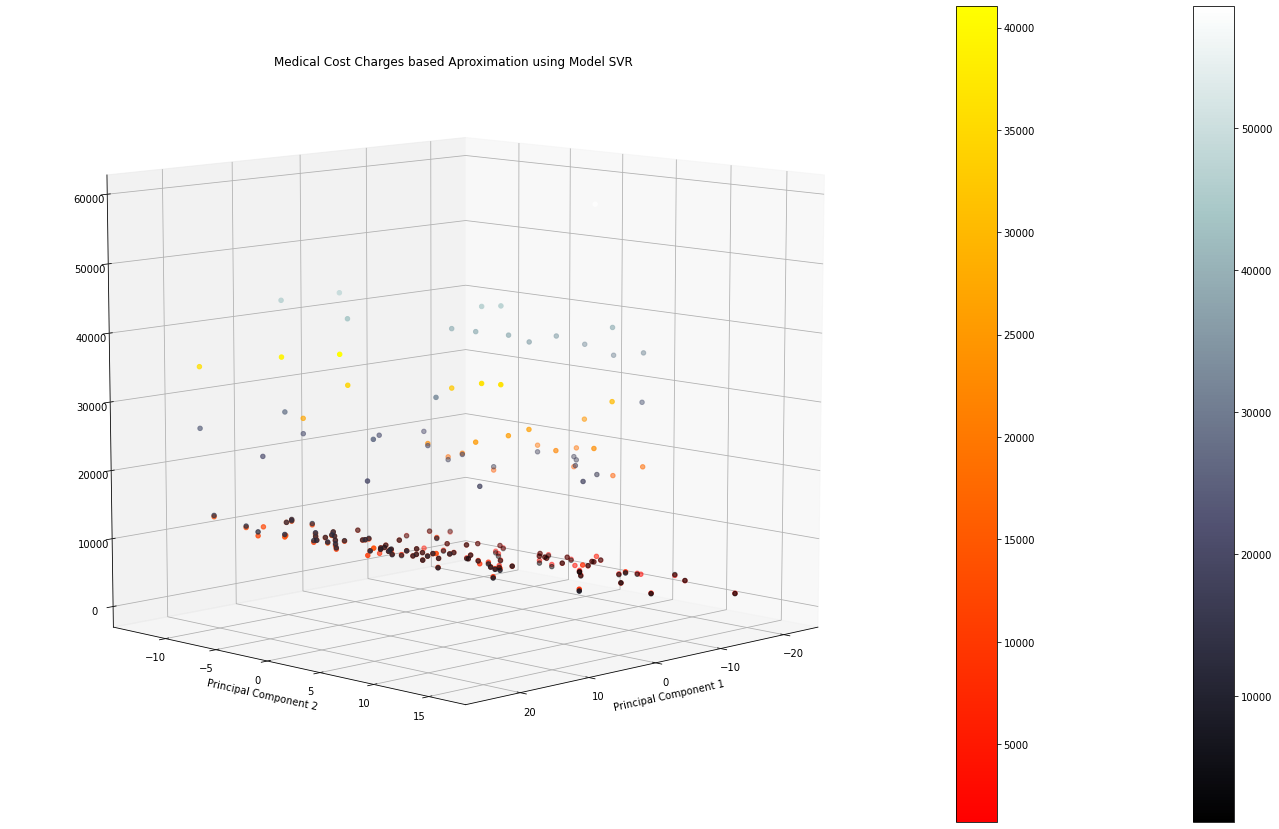

In [42]:
pca = PCA(n_components=2).fit_transform(X_test)

fig = plt.figure(figsize=(25, 15))

ax = fig.add_subplot(projection='3d')  
ax.view_init(10, 45)


scat = ax.scatter(pca[:, 0], pca[:, 1], y_test,  c=y_test, cmap="bone")
scat2 = ax.scatter(pca[:, 0], pca[:, 1], y_hat_test,  c=y_hat_test, cmap="autumn")

# idx = 1;
# for x, y, z in zip(pca[:, 0], pca[:, 1], y_test):    
#     ax.text(x, y, z, idx)
#     idx = idx + 1

# idx = 1
# for x, y, z in zip(pca[:, 0], pca[:, 1], y_hat_test):    
#     ax.text(x, y, z, idx)
#     idx = idx + 1

fig.colorbar(scat)
fig.colorbar(scat2)
ax.set(xlabel='Principal Component 1', ylabel='Principal Component 2', title=f'Medical Cost Charges based Aproximation using Model SVR')  

Viendo el gráfico, podemos observar que al modelo SVR le cuesta bastante aproximar los valores altos, es decir, generar predicciones en los 3 hiperplanos. Esto es otro indicio para afirmar que el modelo que mejor se acomoda a nuestros datos es el Random Forest.